In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras import optimizers
from typing import *

path = os.getcwd()
data_path = os.path.join(path, "data")

In [2]:
data = np.loadtxt(os.path.join(data_path, "data_banknote_authentication.txt"), delimiter=",")
print(data.shape)

(1372, 5)


In [3]:
# Let's extract the two featues   
# x1: skewness of wavelet transformed image.  
# x2: entropy of wavelet transformed image. 
# y: 0-fake, 1-real
X = data[:, [1, 3]]
y = data[:, -1].astype(int)
print(X.shape, y.shape)

(1372, 2) (1372,)


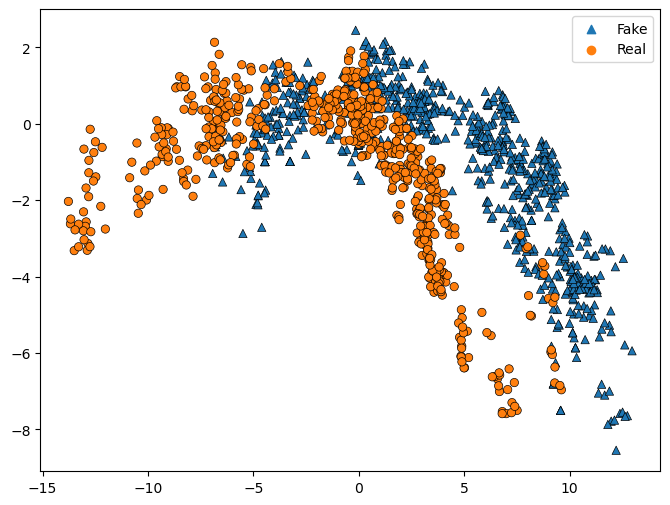

In [4]:
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, style=y, markers={0: "^", 1: "o"}, edgecolor='black', legend="auto")
legend_labels, _ = ax.get_legend_handles_labels()
ax.legend(legend_labels, ["Fake", "Real"], loc="upper right")

In [84]:
def plot_train_loss(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
    metrics = ["accuracy", "loss"]
    
    for ax, metric in zip(axes, metrics):
        ax.plot(history.history[metric])
        ax.set_title(f'model {metric}')
        ax.set_ylabel(metric)
        ax.set_xlabel('epoch')
        ax.legend(['train'], loc='lower right')
    plt.show()

### fcNN with only one neuron
Let’s try to use a single neuron with a sigmoid activation function (also known as logistic regression) as classification model to seperate the banknotes.  
We use the sequential API from keras to build the model. To fit the 3 parameters we use the stochastic gradient descent optimizer with a learning rate of 0.15.

In [82]:
model = Sequential(name="model_1")
model.add(Dense(1, batch_input_shape=(None, 2), activation='sigmoid'))
sgd = optimizers.SGD(learning_rate=0.15)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [83]:
history = model.fit(X, y, epochs=400, batch_size=128, verbose=0)

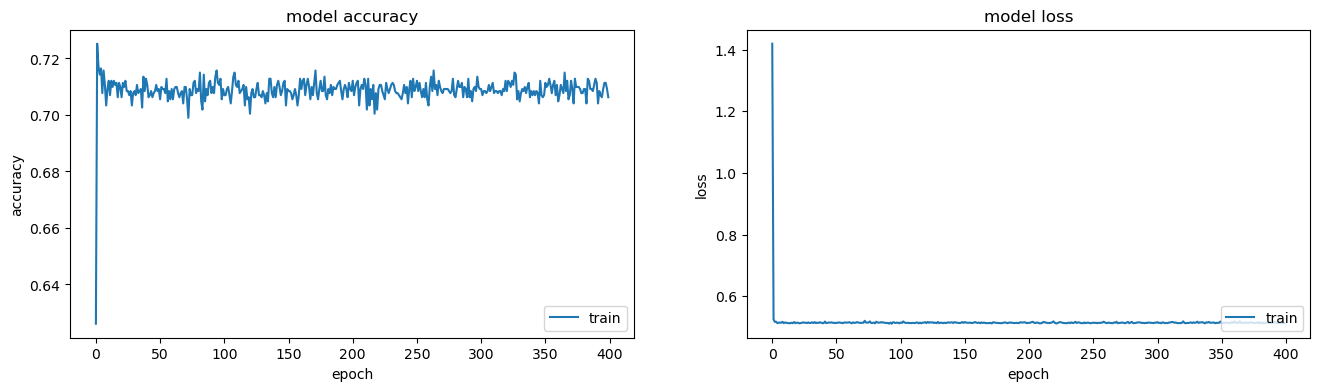

In [85]:
plot_train_loss(history)

### Plotting the learned decision boundary
Let's visualize which decision boundary was learned by the fcNN with only one output neuron (and no hidden layer).  
As you can see the decision boundary is a straight line.  
This is not a coincidence but a general property of a single artificial neuron with a sigmoid as activation function and no hidden layer, also known as logistic regression.

In [93]:
def plot_model(model, X, y, title: str):
    # define a grid for the 2D feature space
    # predict at each grid point the probability for class 1

    x1_list = np.linspace(X[:,0].min() - 2, X[:,0].max() + 2, 50) # Define 50 points on the x-axis
    x2_list = np.linspace(X[:,1].min() - 2, X[:,1].max() + 2, 50) # Define 50 points on the x-axis
    x_grid, y_grid = np.meshgrid(x1_list, x2_list)
    
    points = np.vstack([x_grid.ravel(), y_grid.ravel()]).T
    
    # model.predict for respective value x1 and x2 
    p = model.predict(points)
    print(p.shape)
    if len(p.shape) == 2:
        p = p[:,1] # pick p for class 1 if there are more than 2 classes
    p = np.reshape(p, x_grid.shape)
    
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 4))
    ax = axes[0]
    cp = ax.contourf(x_grid, y_grid, p, cmap="viridis")
    fig.colorbar(cp, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")

    ax = axes[1]
    cp = ax.contourf(x_grid, y_grid, p, cmap="viridis")
    fig.colorbar(cp, ax=ax)
    ax = sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, style=y, markers={0: "^", 1: "o"}, edgecolor='black', legend="auto", ax=ax)
    legend_labels, _ = ax.get_legend_handles_labels()
    ax.legend(legend_labels, ["Fake", "Real"])
    ax.set_title(title)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    plt.show()



(2500, 1)


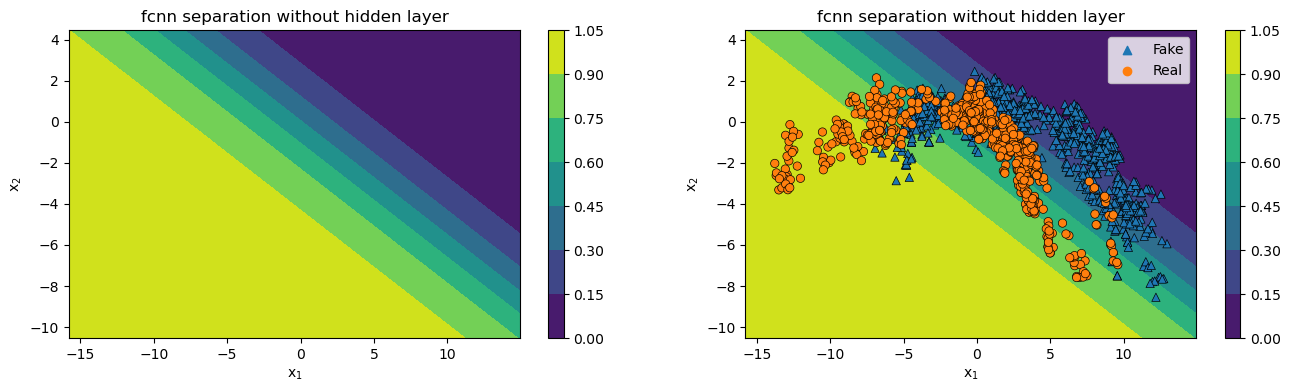

In [68]:
plot_model(model, X, y, "fcnn separation without hidden layer")

### fcNN with one hidden layer 

We know that the boundary between the two classes is not descriped very good by a line. Therefore a single neuron is not appropriate to model the probability for a fake banknote based on its two features. To get a more flexible model, we introduce an additional layer between input layer and output layer. This is called hidden layer. Here we use a hidden layer with 8 neurons. We also change the ouputnodes form 1 to 2, to get two ouputs for the probability of real and fake banknote. Because we now have 2 outputs, we use the *softmax* activation function in the output layer. The softmax activation ensures that the output can be interpreted as a probability (see book for details)

In [86]:
# Definition of the network
model = Sequential(name="model_2")
model.add(Dense(8, batch_input_shape=(None, 2), activation='sigmoid'))
model.add(Dense(2, activation='softmax'))
sgd = optimizers.SGD(learning_rate=0.15)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 8)                 24        
                                                                 
 dense_5 (Dense)             (None, 2)                 18        
                                                                 
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


In [87]:
y_c = to_categorical(y, num_classes=2)
print(y[-5:])
print(y_c[-5:])

[1 1 1 1 1]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [88]:
history = model.fit(X, y_c, epochs=400, batch_size=128, verbose=0)

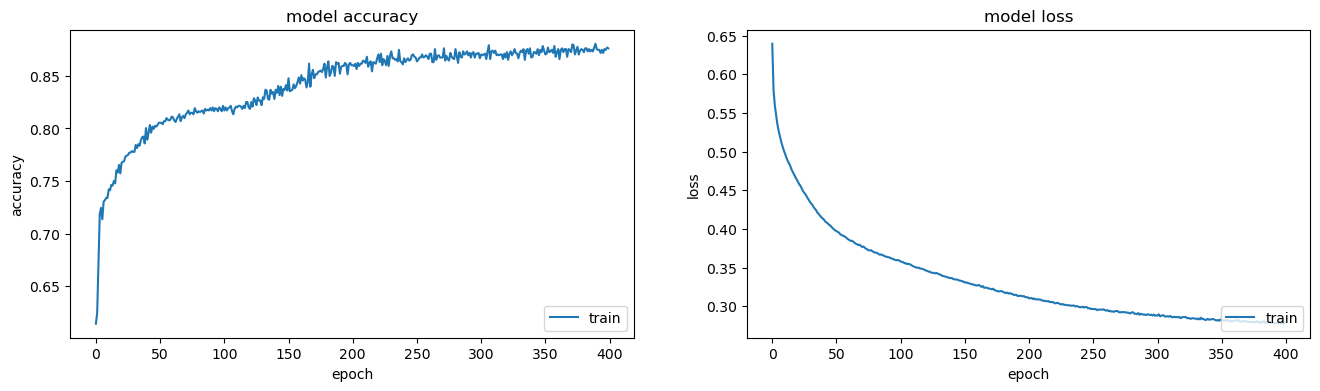

In [89]:
plot_train_loss(history)

(2500, 2)


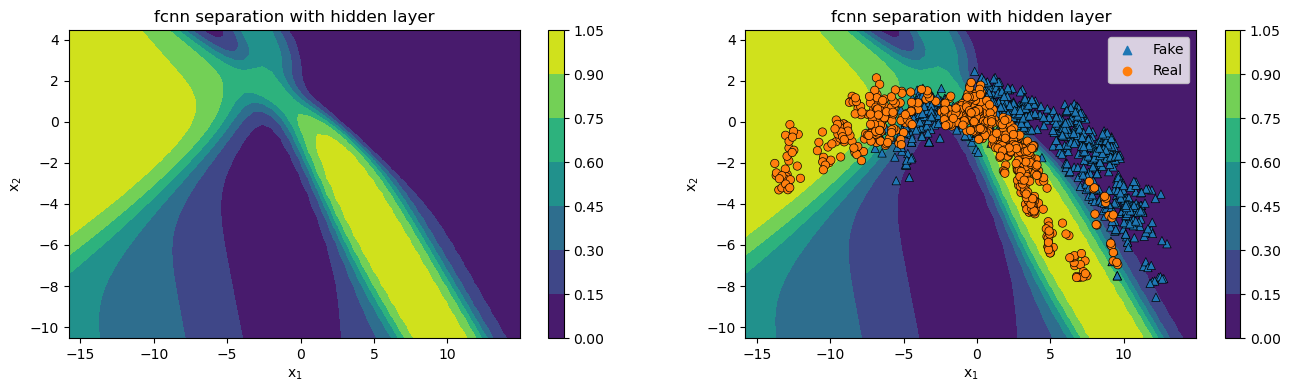

In [94]:
plot_model(model, X, y, "fcnn separation with hidden layer")